In [ ]:
!pip install shap

In [ ]:
!pip install bayesian-optimization

In [ ]:
!pip install --pre pycaret

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from math import sqrt
import os
import missingno as msno
import calendar
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from tqdm.notebook import tqdm
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import Lasso,Ridge
from sklearn.pipeline import Pipeline

import lightgbm as lgbm
from xgboost import XGBClassifier

from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial #함수 고정
import shap

### Data handling

In [ ]:
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

In [ ]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# 예측할때 사용할 수 없는 변수오 'casual'과 'registered'가 있다.
drop_cols = list(set(train.columns) - set(test.columns))
drop_cols.remove('count')
drop_cols

['registered', 'casual']

In [ ]:
# train data로 부터 drop_cols 삭제
train.drop(drop_cols, axis=1, inplace=True)

In [ ]:
# date time handling
train["Day of week"] = train["datetime"].map(lambda x :  calendar.day_name[datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date().weekday()])
train["Year"] = train["datetime"].map(lambda x :  datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year)
train["Month"] = train["datetime"].map(lambda x :  datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month)
train["Day"] = train["datetime"].map(lambda x :  datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').day)
train["Hour"] = train["datetime"].map(lambda x :  datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour)

test["Day of week"] = test["datetime"].map(lambda x :  calendar.day_name[datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date().weekday()])
test["Year"] = test["datetime"].map(lambda x :  datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year)
test["Month"] = test["datetime"].map(lambda x :  datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month)
test["Day"] = test["datetime"].map(lambda x :  datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').day)
test["Hour"] = test["datetime"].map(lambda x :  datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour)

In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Day of week,Year,Month,Day,Hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,Saturday,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,Saturday,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,Saturday,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,Saturday,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,Saturday,2011,1,1,4


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     10886 non-null  object 
 1   season       10886 non-null  int64  
 2   holiday      10886 non-null  int64  
 3   workingday   10886 non-null  int64  
 4   weather      10886 non-null  int64  
 5   temp         10886 non-null  float64
 6   atemp        10886 non-null  float64
 7   humidity     10886 non-null  int64  
 8   windspeed    10886 non-null  float64
 9   count        10886 non-null  int64  
 10  Day of week  10886 non-null  object 
 11  Year         10886 non-null  int64  
 12  Month        10886 non-null  int64  
 13  Day          10886 non-null  int64  
 14  Hour         10886 non-null  int64  
dtypes: float64(3), int64(10), object(2)
memory usage: 1.2+ MB


결측치개수 = 0


<Axes: >

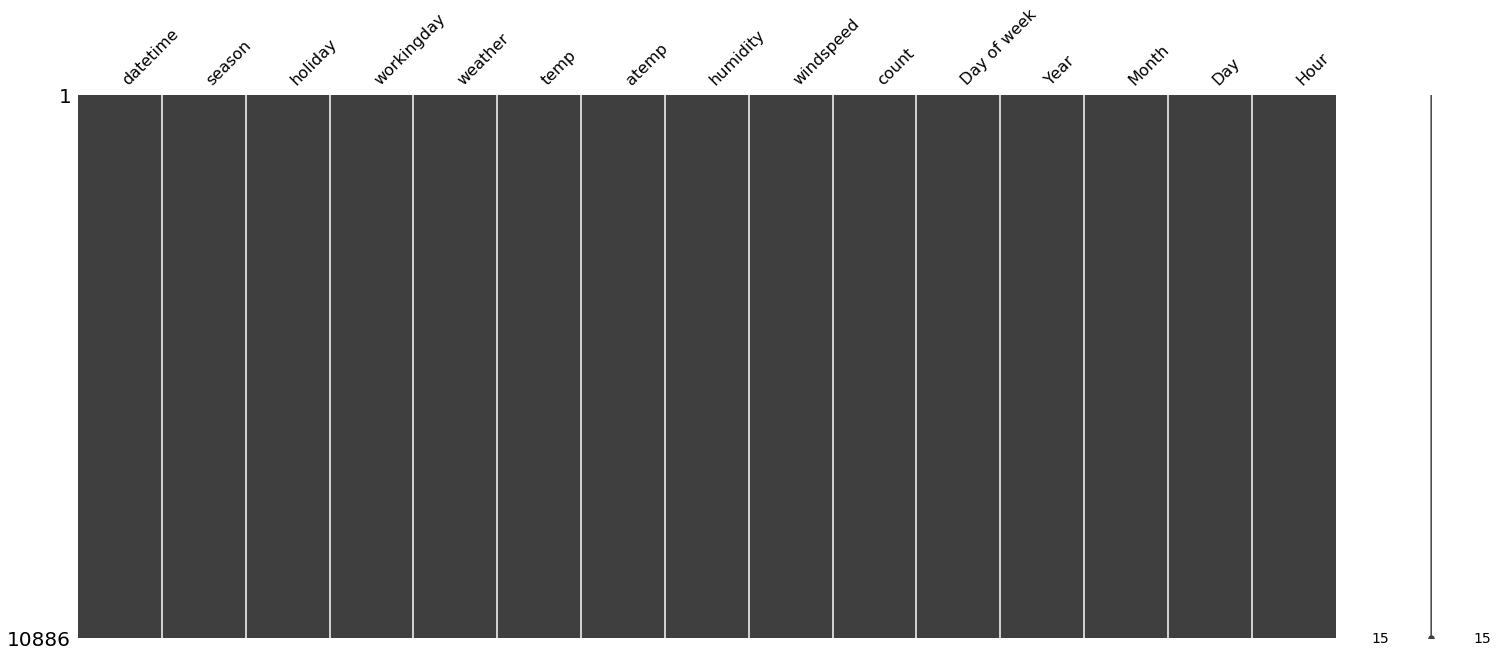

In [ ]:
#결측치 확인, 결측치 시각화
print(f"결측치개수 = {train.isna().sum().sum()}")
msno.matrix(df=train)

In [ ]:
# atemp - "feels like" temperature in Celsius 이기에 제외
train.drop('atemp', axis=1, inplace=True)
test.drop('atemp', axis=1, inplace=True)

### EDA

In [ ]:
# 전체 데이터의 달별 관측치가 적절히 분포해 있는지
month = sorted(train.Month.unique())
x_2011 = list(train.loc[train.Year==2011, "Month"].value_counts().index)
y_2011 = list(train.loc[train.Year==2011, "Month"].value_counts().values)

x_2012 = list(train.loc[train.Year==2012, "Month"].value_counts().index)
y_2012 = list(train.loc[train.Year==2012, "Month"].value_counts().values)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_2011, y=y_2011, mode="markers", name="2011"))
fig.add_trace(go.Scatter(x=x_2012, y=y_2012, mode="markers", name="2012"))

fig.update_layout(title=dict({"text": """Check "is month equaliy distributed in dataset" """}))
fig.update_layout(xaxis=dict({"tickvals": month,
                            "ticktext": [calendar.month_abbr[x] for x in month],
                            "title": "Day of Week"}))
fig.update_layout(yaxis=dict({"title": "Count"}))
fig.show()

In [ ]:
# trian과 test의 day가 곂치치 않음 따라서 day는 사용 X
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Day.unique(), y=[20]*len(train.Hour.unique()), mode="markers", name="train"))
fig.add_trace(go.Scatter(x=test.Day.unique(), y=[10]*len(test.Hour.unique()), mode="markers", name="test"))

fig.update_layout(title=dict({"text": """Days in test and train"""}))
fig.update_layout(yaxis=dict({"tickvals": [10, 20],
                            "ticktext": ["test", "train"]}))
fig.update_layout(xaxis=dict({"title": "Days"}))

fig.show()

In [ ]:
# month별로 자전거 대여의 차이
month = sorted(train.Month.unique())

cnt_2011 = [train.loc[(train.Month==m)&(train.Year==2011) , "count"].sum() for m in month]
cnt_2012 = [train.loc[(train.Month==m)&(train.Year==2012) , "count"].sum() for m in month]
cnt_all = [train.loc[train.Month==m, "count"].sum() for m in month]

fig = go.Figure()
fig.add_trace(go.Scatter(x=month, y=cnt_all, mode="lines", name="2011&2012"))
fig.add_trace(go.Scatter(x=month, y=cnt_2012, mode="lines", name="2012"))
fig.add_trace(go.Scatter(x=month, y=cnt_2011, mode="lines", name="2011"))

fig.update_layout(title=dict({"text": "Month & Count"}))
fig.update_layout(xaxis=dict({"tickvals": month,
                            "ticktext": [calendar.month_abbr[x] for x in month],
                            "title": "Month"}))
fig.update_layout(yaxis=dict({"title": r"$\Sigma count$"}))
fig.show()

위의 결과로 보아 2011년 보다 2012년에 더 자전거 이용대수가 많을 걸 확인할 수 있다. 따라서 year변수를 쓴다면 모델을 예측하는데 있어 유의미한 변수가 되겠지만 예측모델의 의의에 있어서 사용하면 안된다! test data는 2011년과 2012년이 둘다 들어있긴하다!

In [ ]:
#위의 data는 count의 sum으로 해본것이지만 Average로 

fig = go.Figure()
fig.add_trace(go.Scatter(x=month, y=np.array(cnt_2012)//np.array(y_2012), mode="lines", name="2012"))
fig.add_trace(go.Scatter(x=month, y=np.array(cnt_2011)//np.array(y_2011), mode="lines", name="2011"))

fig.update_layout(title=dict({"text": "Month & AVG(Count)"}))
fig.update_layout(xaxis=dict({"tickvals": month,
                            "ticktext": [calendar.month_abbr[x] for x in month],
                            "title": "Month"}))
fig.update_layout(yaxis=dict({"title": "Avg count"}))
fig.show()

위와 같은 양상이 일어나는 이유는 월별 기온때문인거 같아 다음과 같이 temp의 mean을 이용해서 확인

In [ ]:
Temps = [train.loc[train.Month==m, "temp"].mean() for m in month]

fig = go.Figure()
fig.add_trace(go.Scatter(x=month, y=Temps, mode="lines+markers", name="temperatuew"))

fig.update_layout(title=dict({"text": "AVerage Temperature"}))
fig.update_layout(xaxis=dict({"tickvals": month,
                            "ticktext": [calendar.month_abbr[x] for x in month],
                            "title": "Month"}))
fig.update_layout(yaxis=dict({"title": "temp"}))
fig.show()

온도가 높을 수록 cnt의 평균 이 증가하는 걸 볼수 있지만 온도가 제일 높은 한여름인 Jul 같은 경우는 해당 계절에서 제일 낮은 것을 볼 수 있다.

In [ ]:
# season은 어떻게 나누어져 있을까?
# season & month
months = [list(train.loc[train.season==i+1, "Month"].unique()) for i in range(4)] #각 season에 따라서  month 가 어떻게 있는지
x1, x2, x3, x4 = months[0], months[1], months[2], months[3]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x1, y=np.zeros(len(x1)), name="season_1", mode="markers", marker_color="darkgreen"))
fig.add_trace(go.Scatter(x=x2, y=np.zeros(len(x2))+5, name="season_2", mode="markers", marker_color="darkblue"))
fig.add_trace(go.Scatter(x=x3, y=np.zeros(len(x3))+10, name="season_3", mode="markers", marker_color="darkred"))
fig.add_trace(go.Scatter(x=x4, y=np.zeros(len(x4))+15, name="season_4", mode="markers", marker_color="darkorange"))
fig.update_traces(mode="markers", marker_line_width=1, marker_size=10)

fig.update_layout(title=dict({"text": "Season & Month"}))
fig.update_layout(xaxis=dict({"tickvals": np.arange(1, 13, 1),
                            "ticktext": [calendar.month_abbr[x] for x in np.arange(1, 13, 1)],
                            "title": "Month"}))
fig.update_layout(yaxis=dict({"tickvals": [0, 5, 10, 15],
                            "ticktext": ["season"+str(i) for i in range(1, 5)],
                            "title": "season"}))


fig.show()

In [ ]:
#season별 평균 count & 달별 평균 count
y_all = list(train["Month"].value_counts().values)
season_sum = [train.loc[train.season==s, "count"].sum() for s in sorted(train.season.unique()) ]
season_avg = [season_sum[s-1]//train.loc[train.season==s].shape[0] for s in sorted(train.season.unique())]

fig = go.Figure()
fig.add_trace(go.Scatter(x=month, y=np.array(cnt_all)//np.array(list(y_all)), mode="lines+markers", name="Month_AVG"))
fig.add_trace(go.Scatter(x=[2, 5, 8, 11], y=season_avg, mode="markers", name="Season_AVG"))
fig.add_vrect(x0=1, x1=4, line_width=0, fillcolor="blue", opacity=0.2,
              annotation_text="Season_1", 
              annotation_position="bottom right",
              annotation_font_size=20,
              annotation_font_color="black",
              annotation_font_family="Times New Roman")
fig.add_vrect(x0=4, x1=7, line_width=0, fillcolor="green", opacity=0.2,
              annotation_text="Season_2", 
              annotation_position="bottom right",
              annotation_font_size=20,
              annotation_font_color="black",
              annotation_font_family="Times New Roman")
fig.add_vrect(x0=7, x1=10, line_width=0, fillcolor="orange", opacity=0.2,
              annotation_text="Season_3", 
              annotation_position="bottom right",
              annotation_font_size=20,
              annotation_font_color="black",
              annotation_font_family="Times New Roman")
fig.add_vrect(x0=10, x1=12, line_width=0, fillcolor=" blueviolet", opacity=0.2,
              annotation_text="Season_4", 
              annotation_position="bottom right",
              annotation_font_size=20,
              annotation_font_color="black",
              annotation_font_family="Times New Roman")

fig.update_layout(title=dict({"text": "over all Avg count"}))
fig.update_layout(xaxis=dict({"tickvals": month,
                            "ticktext": [calendar.month_abbr[x] for x in month],
                            "title": "Month"}))
fig.update_layout(yaxis=dict({"title": "Avg count"}))
fig.show()

month 와 season 둘다 유의 밀한 변수인걸 대략적으로 알 수 있었다. plus -> season은 카테고리칼 변수 가 아닌 label incoding으로 해볼 수도?

#### holiday와 working day를 day info 하나의 column으로 결합   
working day -> 평일 & not(holiday)
weekday&holiday -> 평일 & holiday
weekend -> 주말

In [ ]:
train["Day_info"] = np.nan*train.shape[0]
train.loc[train.workingday == 1, "Day_info"] = "working day"
train.loc[(train.workingday == 0)&(train.holiday == 1), "Day_info"] = "weekday&holiday"
train.loc[((train["Day of week"]=='Saturday') | (train["Day of week"]=='Sunday'))&(train.holiday==0),  "Day_info"] = "Weekend"

print(train.Day_info.value_counts())
print(train.Day_info.value_counts().sum() == train.shape[0])

working day        7412
Weekend            3163
weekday&holiday     311
Name: Day_info, dtype: int64
True


In [ ]:
test["Day_info"] = np.nan*test.shape[0]
test.loc[test.workingday == 1, "Day_info"] = "working day"
test.loc[(test.workingday == 0)&(test.holiday == 1), "Day_info"] = "weekday&holiday"
test.loc[((test["Day of week"]=='Saturday') | (test["Day of week"]=='Sunday'))&(test.holiday==0),  "Day_info"] = "Weekend"

print(test.Day_info.value_counts())
print(test.Day_info.value_counts().sum() == test.shape[0])

working day        4453
Weekend            1851
weekday&holiday     189
Name: Day_info, dtype: int64
True


In [ ]:
x = list(train.Day_info.unique())
day_info_cnt = [train.loc[train.Day_info==d, "count"].mean() for d in train.Day_info.unique()]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=day_info_cnt, mode="lines+markers", name="temperatuew"))

fig.update_layout(title=dict({"text": "AVerage Day_info"}))
fig.update_layout(xaxis=dict({"tickvals": x,
                            "title": "Day_info"}))
fig.update_layout(yaxis=dict({"title": "AVG count"}))
fig.show()

In [ ]:
fig = px.box(train, x="Day_info", y="count")
fig.show()

주말이나 공휴일에 많이 빌릴것으로 예상했는데 오히려 working day 에 많이 빌리는것을 확인할 수 있었다.

In [ ]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'count', 'Day of week', 'Year', 'Month', 'Day',
       'Hour', 'Day_info'],
      dtype='object')

In [ ]:
sssssssssssssssssssssssssx = list(train.weather.unique())
weather_cnt = [train.loc[train.weather==w, "count"].mean() for w in train.weather.unique()]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=weather_cnt, mode="lines+markers", name="temperatuew"))

fig.update_layout(title=dict({"text": "AVerage weather"}))
fig.update_layout(xaxis=dict({"tickvals": x,
                              "ticktext": ['Clear', 
                                         'Mist, Few clouds', 
                                         'Light Snow, Rain, Thunder', 
                                         'Heavy Snow, Rain, Thunder'],
                            "title": "weather"}))
fig.update_layout(yaxis=dict({"title": "AVG count"}))
fig.show()

In [ ]:
fig = px.box(train, x="weather", y="count")
fig.show()

In [ ]:
train.loc[train.weather==4]

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count,Day of week,Year,Month,Day,Hour,Day_info
5631,2012-01-09 18:00:00,1,0,1,4,8.2,86,6.0032,164,Monday,2012,1,9,18,working day


weather이 4인것은 단 한개뿐 따라서 weather 4인것을 3으로 바꿔주기

In [ ]:
train.loc[train.weather==4, "weather"] = 3
test.loc[test.weather==4, "weather"] = 3

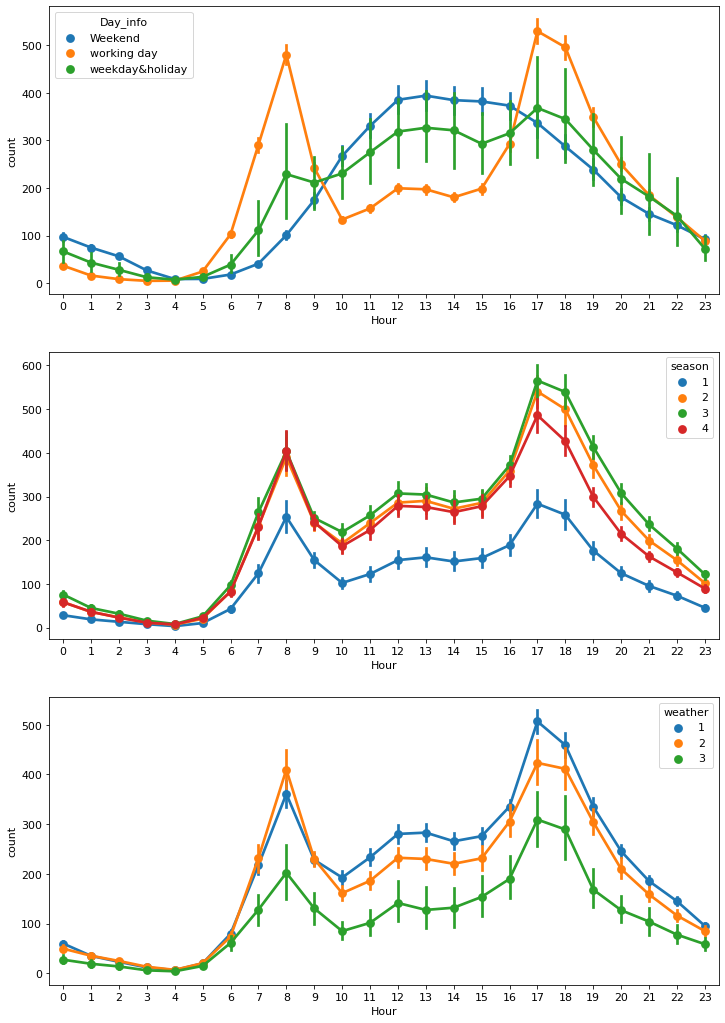

In [ ]:
# hour
import matplotlib as mpl

# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=3) # 5행 1열
figure.set_size_inches(12, 18)

# 스텝 2 : 서브플롯 할당
# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트플롯
sns.pointplot(x='Hour', y='count', data=train, hue='Day_info', ax=axes[0])
sns.pointplot(x='Hour', y='count', data=train, hue='season', ax=axes[1])
sns.pointplot(x='Hour', y='count', data=train, hue='weather', ax=axes[2]);

In [ ]:
# weather이 1인것을 good, soso, bad로 카테고리형으로 change
train['weather'] = train['weather'].map({1: 'Good', 
                                         2: 'soso', 
                                         3: 'bad'})

test['weather'] = test['weather'].map({1: 'Good', 
                                         2: 'soso', 
                                         3: 'bad'})

In [ ]:
#humidity에 따른 습도

In [ ]:
#hour sin, cos 변환
train['sin_hour'] = np.sin(2*np.pi*train.Hour/24)
train['cos_hour'] = np.cos(2*np.pi*train.Hour/24)

test['sin_hour'] = np.sin(2*np.pi*test.Hour/24)
test['cos_hour'] = np.cos(2*np.pi*test.Hour/24)

In [ ]:
fig = px.scatter(train, x='sin_hour', y='cos_hour',
                 hover_data=["Hour"], width=400, height=400)
fig.show()

In [ ]:
train.to_csv("train_eda.csv")

In [ ]:
test.to_csv("test_eda.csv")

### Pycaret

### LGBM Regressor

In [ ]:
# Multi label encoder(https://hongl.tistory.com/263)
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

class MultiColLabelEncoder:
    def __init__(self):
        self.encoder_dict = defaultdict(LabelEncoder)

    def fit_transform(self, X: pd.DataFrame, columns: list):
        if not isinstance(columns, list):
            columns = [columns]

        output = X.copy()
        output[columns] = X[columns].apply(lambda x: self.encoder_dict[x.name].fit_transform(x))

        return output
    
    def inverse_transform(self, X: pd.DataFrame, columns: list):
        if not isinstance(columns, list):
            columns = [columns]
        
        if not all(key in self.encoder_dict for key in columns):
            raise KeyError(f"At leat one of {columns} is not encoded before")
        
        output = X.copy()
        try:
            output[columns] = X[columns].apply(lambda x:
                                               self.encoder_dict[x.name].inverse_transform(x))
        except ValueError:
            print("""Need assingment when do "fit_transform" function""")
            raise
        
        return output

In [ ]:
train.head(2)

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count,Day of week,Year,Month,Day,Hour,Day_info
0,2011-01-01 00:00:00,1,0,0,Good,9.84,81,0.0,16,Saturday,2011,1,1,0,Weekend
1,2011-01-01 01:00:00,1,0,0,Good,9.02,80,0.0,40,Saturday,2011,1,1,1,Weekend


역변환 코드 train_inversed = mcle.inverse_transform(X=train_transformed, columns=labels)

In [ ]:
mcle_train = MultiColLabelEncoder()
mcle_test = MultiColLabelEncoder()

labels = ["weather", "Day of week", "Day_info"]
train_transformed = mcle_train.fit_transform(X=train, columns=labels)
test_transformed = mcle_test.fit_transform(X=train, columns=labels)

In [ ]:
# 카테고리 데이터 바꿔주기
cat_col = ["season", "weather", "Day of week", "Month", "Hour", "Day_info"]
# for col in cat_col:
#     train_transformed[col] = train_transformed[col].astype("category")
#     train_transformed[col] = train_transformed[col].astype("category")

c_t = ["season", "Month", "Hour"]
for col in c_t:
    train_transformed[col] = train_transformed[col].astype("int")
    train_transformed[col] = train_transformed[col].astype("int")


In [ ]:
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Year", "Day", target_col]

X, y = train_transformed.drop(drop_cols, axis=1), train_transformed[target_col]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

x_train.head()

,season,weather,temp,humidity,windspeed,Day of week,Month,Hour,Day_info
0,3,0,28.70,65,12.9980,1,7,0,2
1,2,0,22.96,52,22.0028,0,5,22,2
2,2,0,12.30,61,6.0032,0,4,23,2
3,3,0,23.78,60,8.9981,3,9,9,0
4,1,1,8.20,93,12.9980,5,2,23,2


In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164 entries, 0 to 8163
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       8164 non-null   int64  
 1   weather      8164 non-null   int64  
 2   temp         8164 non-null   float64
 3   humidity     8164 non-null   int64  
 4   windspeed    8164 non-null   float64
 5   Day of week  8164 non-null   int64  
 6   Month        8164 non-null   int64  
 7   Hour         8164 non-null   int64  
 8   Day_info     8164 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 574.2 KB


In [ ]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda, x_data=None, y_data=None, n_splits=5, random_state=2023):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    score = 0

    #local_train, local_valid를 5번 만들어서 수행
    for train_index, valid_index in kf.split(X=x_data, y=y_data):
        x_train, y_train = x_data.iloc[train_index], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data[valid_index]
        
        model = lgbm.LGBMRegressor(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate,
            n_estimators = int(n_estimators), 
            subsample = np.clip(subsample, 0, 1), 
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
        )
        
        model.fit(x_train, y_train,
                  eval_set=[(x_valid, y_valid)],
                  early_stopping_rounds=50,
                  verbose = -1,
                  eval_metric='rmse',
                  categorical_feature=["season", "weather", "Day of week", "Month", "Hour", "Day_info"])

        
        pred = model.predict(x_valid)
        true = y_valid
        score += mean_squared_error(true, pred, squared=False)/n_splits
    
    return -score

In [ ]:
import time

# 모델과 관련없는 변수 고정
func_fixed = partial(lgb_cv, x_data=x_train, y_data=y_train, n_splits=5, random_state=2023)

# 베이지안 최적화 범위 설정
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (25, 45),        # num_leaves,
        'learning_rate': (0.01, 0.1),  # learning_rate,  
        'n_estimators': (100, 1000),      # n_estimators,     
        'subsample': (0.3, 0.7),             # subsample,       
        'colsample_bytree': (0.3, 0.7),      # colsample_bytree
        'reg_alpha': (0, 0.1),            # reg_alpha,       
        'reg_lambda': (0, 0.1),           # reg_lambda,       
    }, 
    random_state=2023                 # 시드 고정
)

start_time=time.time()
lgbBO.maximize(init_points=10, n_iter=50) # 처음 5회 랜덤 값으로 score 계산 후 30회 최적화
print("---%s seconds ---" % (time.time() - start_time))

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

| 1         | -67.9     | 0.4288    | 0.09014   | 629.2     | 27.53     | 0.01413   | 0.04679   | 0.3088    |


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

| 2         | -64.71    | 0.5909    | 0.05719   | 590.4     | 34.13     | 0.05014   | 0.03945   | 0.3605    |


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

| 3         | -69.18    | 0.4444    | 0.02459   | 404.2     | 28.61     | 0.0391    | 0.003565  | 0.5259    |


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

| 4         | -69.38    | 0.3814    | 0.03885   | 438.9     | 28.68     | 0.0104    | 0.04549   | 0.3783    |


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

| 5         | -68.07    | 0.4514    | 0.09375   | 784.1     | 40.42     | 0.05967   | 0.07916   | 0.6241    |


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

| 6         | -65.38    | 0.6922    | 0.08963   | 198.8     | 41.39     | 0.03076   | 0.02615   | 0.4623    |


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

| 7         | -67.16    | 0.5214    | 0.0663    | 170.9     | 44.45     | 0.04113   | 0.07217   | 0.5653    |


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

| 8         | -68.83    | 0.3873    | 0.02685   | 756.8     | 42.27     | 0.03917   | 0.011     | 0.6651    |


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

| 9         | -68.55    | 0.4428    | 0.04717   | 265.2     | 36.72     | 0.08557   | 0.07897   | 0.3351    |


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

| 10        | -64.76    | 0.6732    | 0.055     | 427.8     | 34.67     | 0.05152   | 0.09946   | 0.6014    |


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

| 11        | -64.76    | 0.5082    | 0.04497   | 755.0     | 37.83     | 0.05349   | 0.01394   | 0.5012    |


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Day of week', 'Day_info', 'Hour', 'Month', 'season', 'weather']

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513

KeyboardInterrupt: ignored